# Compute Inferential Statistics

### import modules

In [1]:
import json
import pickle

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from matplotlib import animation
from IPython.display import HTML

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### load settings

In [2]:
with open('../models/palette.pkl', 'rb') as fp:
    color_palette = pickle.load(fp)
    
with open('../models/average_im_dict.pkl', 'rb') as fp:
    avg_im_dict = pickle.load(fp)

with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

my_order = settings_dict['my_order']
my_boot = settings_dict['boots']
my_ci = settings_dict['ci']

## Get Data

### get click data

In [3]:
click_diff_correct_df = pd.read_csv('../data/processed/click_diff_correct_df.tsv', sep='\t', index_col=[0])
click_diff_correct_df.tail()

Angry  Disgusted   Fearful  Happy   Neutral       Sad  Surprised
p228  0.320000   0.060000  0.250000  -0.21  0.100000  0.133333   0.155556
p230  0.077778   0.044444  0.100000   0.02  0.062500  0.122222   0.155556
p231  0.160000   0.037500  0.088889   0.03  0.042857 -0.016667   0.110000
p232  0.122222   0.033333  0.125000  -0.19  0.077778  0.066667   0.110000
p233  0.340000   0.188889  0.100000  -0.01  0.083333  0.137500   0.077778

#### Reshape into Wide Format

In [4]:
click_diff_correct_df = click_diff_correct_df.loc[:, my_order]
click_diff_correct_df.tail()

Happy  Disgusted   Neutral     Angry       Sad   Fearful  Surprised
p228  -0.21   0.060000  0.100000  0.320000  0.133333  0.250000   0.155556
p230   0.02   0.044444  0.062500  0.077778  0.122222  0.100000   0.155556
p231   0.03   0.037500  0.042857  0.160000 -0.016667  0.088889   0.110000
p232  -0.19   0.033333  0.077778  0.122222  0.066667  0.125000   0.110000
p233  -0.01   0.188889  0.083333  0.340000  0.137500  0.100000   0.077778

#### What to do if no correct answer was given?

Decision here: replace with zero

In [5]:
click_diff_correct_df = click_diff_correct_df.fillna(0)

### get answer count data

In [6]:
ans_df = pd.read_csv('../data/processed/big_correct_df.tsv', sep='\t', index_col=[0], header=[0, 1])

#### get Upper-Lower difference in Answers

In [7]:
ans_diff_df = ans_df['Upper'] - ans_df['Lower']
ans_diff_df = ans_diff_df.loc[:, my_order]
ans_diff_df.tail()

Happy  Disgusted  Neutral  Angry  Sad  Fearful  Surprised
p228   -0.2       -0.4     -0.2    0.3  0.1      0.4       -0.1
p230   -0.1       -0.4     -0.1    0.2  0.1      0.2        0.2
p231   -0.1       -0.8     -0.1    0.6 -0.4     -0.5        0.2
p232   -0.1       -0.6     -0.4    0.2  0.0      0.3        0.0
p233   -0.1       -0.3      0.1    0.9  0.4      0.3        0.0

## Inferential Statistics

### make statistics

In [8]:
def make_stat(diff):
    
    t, tp = stats.ttest_1samp(diff, 0, alternative='two-sided')
    w, wp = stats.wilcoxon(diff, alternative='two-sided', zero_method='zsplit')

    d = {'t': t,
         'tp': tp,
         'w': w,
         'wp': wp,
        }
    
    return d

### threshold raw data according to p-value

In [9]:
def make_thresh(c1, c2, stat_df, thresh):
    
    this_df = stat_df.loc[(c1, c2)].T
    
    descriptive = this_df.loc[:, 'mean diff']
    
    inferential = abs(this_df.loc[:, 'tp'])
    mask = inferential < thresh
    
    descriptive_masked = descriptive * mask
    descriptive_masked = descriptive_masked.replace(0, np.nan).values

    return descriptive_masked

### make all pairwise tests

In [10]:
def make_paired_test(click_diff_correct_df):
    
    d = {}
    
    for c1 in my_order:
        
        for c2 in my_order:
            
            this_set = set([c1, c2])
            diff = click_diff_correct_df[c1] - click_diff_correct_df[c2]

            this_d = make_stat(diff)
            this_d['mean diff'] = diff.mean()

            d[(c1, c2)] = this_d
    
    stats_df = pd.DataFrame(d).T
    stats_df = stats_df.sort_index()
    
    return stats_df

## Stats for Clicks

In [11]:
stats_df = make_paired_test(click_diff_correct_df)
stats_df.tail()

t            tp        w            wp  mean diff
Surprised Fearful     5.580922  7.676998e-08   5657.0  3.326751e-08   0.041309
          Happy      23.198099  9.580626e-59     80.5  2.228370e-34   0.249928
          Neutral    14.553671  3.027442e-33   1069.0  2.486231e-28   0.133055
          Sad         9.323506  2.080931e-17   3073.0  6.157452e-18   0.077244
          Surprised        NaN           NaN  10251.5  1.000000e+00   0.000000

### mask data based on significance

In [12]:
def make_masked_stats(stats_df, settings_dict=settings_dict):
    
    # get significance 
    my_sig = stats_df.loc[:, 'tp'].fillna(99)<settings_dict['p']
    
    # get raw data, but only for significant values!
    # this removes the non-sig from the dataframe
    only_sig_diff = stats_df.loc[my_sig, 'mean diff']
    
    # reordering the reduced data into an nxn matrix replaces the non-sig values by nan
    my_matrix = only_sig_diff.unstack()

    # order according to effects
    this_order = only_sig_diff.groupby(level=0).mean().sort_values().index[::-1]
    ordered_matrix = my_matrix.loc[this_order, this_order[::-1]]

    return ordered_matrix

In [13]:
ordered_matrix = make_masked_stats(stats_df)
ordered_matrix

Happy  Disgusted   Neutral     Angry       Sad   Fearful  \
Surprised  0.249928   0.178011  0.133055  0.080244  0.077244  0.041309   
Fearful    0.208619   0.136703  0.091746       NaN       NaN       NaN   
Sad        0.172683   0.100767  0.055811       NaN       NaN       NaN   
Angry      0.169684   0.097768  0.052811       NaN       NaN       NaN   
Neutral    0.116873        NaN       NaN -0.052811 -0.055811 -0.091746   
Disgusted  0.071916        NaN       NaN -0.097768 -0.100767 -0.136703   
Happy           NaN  -0.071916 -0.116873 -0.169684 -0.172683 -0.208619   

           Surprised  
Surprised        NaN  
Fearful    -0.041309  
Sad        -0.077244  
Angry      -0.080244  
Neutral    -0.133055  
Disgusted  -0.178011  
Happy      -0.249928

<AxesSubplot:>

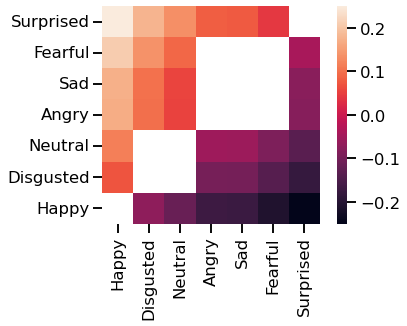

In [14]:
sns.heatmap(ordered_matrix, square=True)

### make mask for upper left triangle

In [15]:
def make_triangle_mask(matrix):
    
    mask = np.zeros_like(matrix)
    mask[np.triu_indices_from(mask)] = True
    mask = mask[::-1]
    
    return mask

In [16]:
mask = make_triangle_mask(ordered_matrix)
mask

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

<AxesSubplot:>

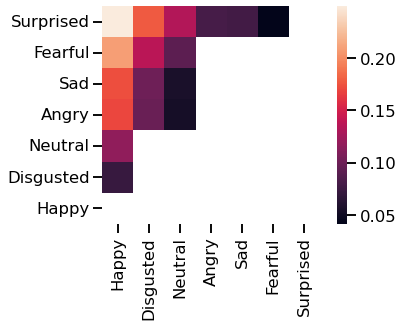

In [17]:
sns.heatmap(ordered_matrix, mask=mask ,square=True)

### order full data into n x n matrix

In [18]:
my_order = ordered_matrix.index

In [19]:
full_matrix = stats_df.loc[:, 'mean diff'].unstack()
full_matrix = full_matrix.loc[my_order, my_order[::-1]]
full_matrix

Happy  Disgusted   Neutral     Angry       Sad   Fearful  \
Surprised  0.249928   0.178011  0.133055  0.080244  0.077244  0.041309   
Fearful    0.208619   0.136703  0.091746  0.038935  0.035936  0.000000   
Sad        0.172683   0.100767  0.055811  0.003000  0.000000 -0.035936   
Angry      0.169684   0.097768  0.052811  0.000000 -0.003000 -0.038935   
Neutral    0.116873   0.044957  0.000000 -0.052811 -0.055811 -0.091746   
Disgusted  0.071916   0.000000 -0.044957 -0.097768 -0.100767 -0.136703   
Happy      0.000000  -0.071916 -0.116873 -0.169684 -0.172683 -0.208619   

           Surprised  
Surprised   0.000000  
Fearful    -0.041309  
Sad        -0.077244  
Angry      -0.080244  
Neutral    -0.133055  
Disgusted  -0.178011  
Happy      -0.249928

In [20]:
# only non-sig values
clean_full_matrix = (full_matrix*(ordered_matrix!=ordered_matrix)).replace(0, np.nan)

### make heatmap

In [21]:
def make_plot(full_matrix, ordered_matrix, ax, color_palette=color_palette):

    my_max = abs(ordered_matrix).max().max()

    sns.heatmap(full_matrix, 
                mask=mask, 
                annot=True, 
                fmt='.0%', 
                square=True, 
                cmap='Greys', 
                vmin=-my_max, 
                vmax=my_max, 
                cbar=False,
                ax=ax)

    sns.heatmap(ordered_matrix, 
                mask=mask, 
                annot=True, 
                fmt='.0%', 
                square=True, 
                cmap=color_palette, 
                vmin=-my_max, 
                vmax=my_max, 
                cbar=False,
                ax=ax)

    ax.set_xlim(0,6,1)
    ax.set_ylim(6,0,-1)

    return ax

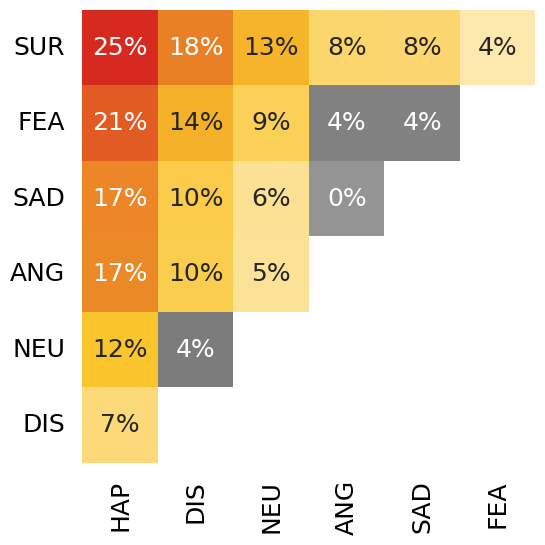

In [22]:
plt.figure(figsize=(6, 6), dpi=100)

ax = plt.subplot(1, 1, 1)
ax = make_plot(clean_full_matrix, ordered_matrix, ax)

ax.set_xticklabels([i.get_text().upper()[:3] for i in ax.get_xticklabels()], fontsize=18)
ax.set_yticklabels([i.get_text().upper()[:3] for i in ax.get_yticklabels()], fontsize=18)

ax.tick_params(bottom=False, left=False)

plt.savefig('../reports/figures/click_stat_fig.png', bbox_inches='tight', dpi=300)

plt.show()

## For Click Numbers

In [23]:
stats_df = make_paired_test(ans_diff_df)

ordered_matrix = make_masked_stats(stats_df)
ordered_matrix = ordered_matrix.loc[my_order, my_order[::-1]] # adjust to click order

full_matrix = stats_df.loc[:, 'mean diff'].unstack()
full_matrix = full_matrix.loc[my_order, my_order[::-1]]
clean_full_matrix = (full_matrix*(ordered_matrix!=ordered_matrix)).replace(0, np.nan)

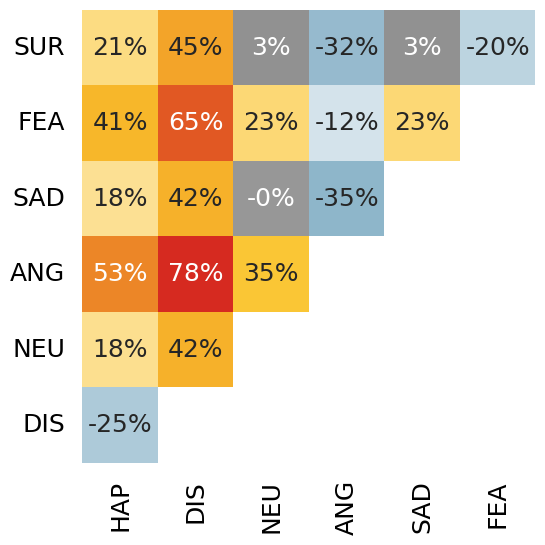

In [24]:
plt.figure(figsize=(6, 6), dpi=100)

ax = plt.subplot(1, 1, 1)
ax = make_plot(clean_full_matrix, ordered_matrix, ax)

ax.set_xticklabels([i.get_text().upper()[:3] for i in ax.get_xticklabels()], fontsize=18)
ax.set_yticklabels([i.get_text().upper()[:3] for i in ax.get_yticklabels()], fontsize=18)

ax.tick_params(bottom=False, left=False)

plt.savefig('../reports/figures/ans_stat_fig.png', bbox_inches='tight', dpi=300)
plt.show()